# Setup🏗️

Imports, run first!

In [ ]:
#Data manipulation:

import numpy as np
import pandas as pd

#Plotting:

import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

#Machine learning:

import sklearn.metrics as sm
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from generate_dataset import dat_2_dataset

#Misc :

from tqdm import tqdm   #To generate progress bars for slow scripts
import pickle           #To save ML models
from prettytable import PrettyTable, ALL


Definitions of path names and other things, for simpler to read code.

In [ ]:
tec_SW  = "small_wave/tec.dat"
mesh_SW = "small_wave/mesh.dat"
tec_LW  = "large_wave/tec.dat"
mesh_LW = "large_wave/mesh.dat"
tec_OH  = "one_hill/tec.dat"
mesh_OH = "one_hill/mesh.dat"
tec_TH  = "two_hills/tec.dat"
mesh_TH = "two_hills/mesh.dat"

A collection of methods, run before executing any code below. Consider putting these into separate files and importing the methods.


In [27]:
# Method for scaling every column in a dataframe, returns a copy of the dataframe with all variables scaled.
def scale_df(df:pd.DataFrame) -> pd.DataFrame:
    df_temp = df.copy(deep=True)
    for col in df.columns:
        df_temp[col] = StandardScaler().fit_transform(df[[col]])
        
    return df_temp 

# Takes a dataframe, x, y, z variables(as specific columns in that dataframe), and a title string and produces a 3d scatter plot. 
# The name of the dataframe columns will be used as axis names.
def scatter_3d(df:pd.DataFrame,x:pd.DataFrame,y:pd.DataFrame,z:pd.DataFrame, title:str):
    fig = px.scatter_3d(df, 
                    x=x, 
                    y=y, 
                    z=z, 
                    opacity=0.8, color_discrete_sequence=[z],
                    height=1000, width=1000
                   )

    # Set figure title
    fig.update_layout(title_text=title,
                    scene_camera_eye=dict(x=1.5, y=1.5, z=0.25), 
                    scene_camera_center=dict(x=0, y=0, z=-0.2),
                    scene = dict(xaxis=dict(backgroundcolor='white',
                                            color='black',
                                            gridcolor='lightgrey'),
                                yaxis=dict(backgroundcolor='white',
                                            color='black',
                                            gridcolor='lightgrey'
                                            ),
                                zaxis=dict(backgroundcolor='white',
                                            color='black', 
                                            gridcolor='lightgrey')))

    # Update marker size
    fig.update_traces(marker=dict(size=2))

    fig.show()
    #scatter_3d(df_SW,df_SW_scaled['x'],df_SW_scaled['y'],df_SW['duidxj'],"")

# Takes a dataframe, x, y, z variables(as specific columns in that dataframe), a pre trained model(obviously trained on the same variables),
# and a title string and produces a 3d scatter plot. The name of the dataframe columns will be used as axis names.
def scatter_w_pred(df,x,y,z,model,title):

    fig = px.scatter_3d(df, 
                    x=x, 
                    y=y, 
                    z=z, 
                    opacity=0.8, color_discrete_sequence=['black'],
                    height=1000, width=1000
                   )

    # Set figure title
    fig.update_layout(title_text=title,
                    scene_camera_eye=dict(x=1.5, y=1.5, z=0.25), 
                    scene_camera_center=dict(x=0, y=0, z=-0.2),
                    scene = dict(xaxis=dict(backgroundcolor='white',
                                            color='black',
                                            gridcolor='lightgrey'),
                                yaxis=dict(backgroundcolor='white',
                                            color='black',
                                            gridcolor='lightgrey'
                                            ),
                                zaxis=dict(backgroundcolor='white',
                                            color='black', 
                                            gridcolor='lightgrey',
                                        )))

    # Update marker size
    fig.update_traces(marker=dict(size=2))

     # ----------- For creating a prediciton plane to be used in the visualization -----------
    # Set Increments between points in a meshgrid
    mesh_size = .1
    # Return evenly spaced values based on a range between min and max
    xrange = np.arange(x.min(), x.max(), mesh_size)
    yrange = np.arange(y.min(), y.max(), mesh_size)
    # Create a meshgrid
    xx, yy = np.meshgrid(xrange, yrange)
    # Make predictions
    pred = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Add prediction plane
    fig.add_traces(go.Surface(x=xrange, y=yrange, z=pred, name='prediction', 
                            colorscale=px.colors.sequential.Sunsetdark,opacity=.8,
                            showscale=False))

    fig.show()

# Takes a domain, cmu prediction in that domain, and cmu in the domain and plots both in the domain as a countour plot. 
def cmu_v_pred_in_domain(x,y,pred,real,title):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))
    fig.suptitle(title)
    
    jet    = plt.get_cmap('jet')
    cmu_range = np.linspace(-1,3.1,50)

    cmu_pred = ax1.contourf(x,y,pred,levels=cmu_range,cmap= jet)
    cmu      = ax2.contourf(x,y,real,levels=cmu_range,cmap= jet)

    fig.colorbar(cmu_pred,ax=ax1)
    fig.colorbar(cmu,ax=ax2)

    ax1.set_title('predicted $C_{my}$')
    ax2.set_title('$C_{my}$')

    plt.show()
    
# Countour plots the input variables dudx, dvdx, dudy, dvdy, duidxj, cmy, u, v, uu, and vv in the domain [x,y], 
# then adds a lovely title on top so that the user will know what dataset they are looking at.
def var_in_domain(x,y,dudx,dvdx,dudy,dvdy,duidxj,cmy,u,v,uu,vv,ww,k,title):
    
    fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8),(ax9,ax10),(ax11, ax12)) = plt.subplots(6,2, figsize=(16,18))
    fig.suptitle(title)

    jet = plt.get_cmap('jet')

    dudx   = ax1.contourf(x,y,dudx,levels=200 ,cmap= jet)
    dvdx   = ax2.contourf(x,y,dvdx,levels=200,cmap= jet)
    dudy   = ax3.contourf(x,y,dudy,levels=200,cmap= jet)
    dvdy   = ax4.contourf(x,y,dvdy,levels=200,cmap= jet)
    duidxj = ax5.contourf(x,y,duidxj,levels=200,cmap= jet)
    cmy    = ax6.contourf(x,y,cmy,levels=200,cmap= jet)
    u      = ax7.contourf(x,y,u,levels=200,cmap= jet)
    v      = ax8.contourf(x,y,v,levels=200,cmap= jet)
    uu     = ax9.contourf(x,y,uu,levels=200,cmap= jet)
    vv     = ax10.contourf(x,y,vv,levels=200,cmap= jet)
    ww     = ax11.contour(x,y,ww,levels=200, cmap= jet)
    k      = ax12.contourf(x,y,k,levels=200,cmap= jet)

    fig.colorbar(dudx,ax=ax1)
    fig.colorbar(dvdx,ax=ax2)
    fig.colorbar(dudy,ax=ax3)
    fig.colorbar(dvdy,ax=ax4)
    fig.colorbar(duidxj,ax=ax5)
    fig.colorbar(cmy,ax=ax6,)
    fig.colorbar(u,ax=ax7,)
    fig.colorbar(v,ax=ax8,)
    fig.colorbar(uu,ax=ax9,)
    fig.colorbar(vv,ax=ax10,)
    fig.colorbar(ww, ax=ax11,)
    fig.colorbar(k, ax=ax12,)

    ax1.set_title('$dudx$')
    ax2.set_title('$dvdx$')
    ax3.set_title('$dudy$')
    ax4.set_title('$dvdy$')
    ax5.set_title('$duidxj$')
    ax6.set_title('$C_{my}$')
    ax7.set_title('$u$')
    ax8.set_title('$v$')
    ax9.set_title('$uu$')
    ax10.set_title('$vv$')
    ax11.set_title("$ww$")
    ax12.set_title("$k$")

    plt.show()
        
# X/Y _train, and X/Y _test should be dataframes. 
# start_range > 0
# Since this method fits a SVR model several times it is not great for large dataframes or large tics_in_range
def tune_c(X_train, Y_train, X_test, Y_test, start_range, end_range, tics_in_range):    
    mae = []    
    eps_perc = []

    c_range = np.linspace(start_range, end_range, num=tics_in_range)
    eps = 0.01

    for c in tqdm(c_range):
        
        varied_svr = SVR(kernel = 'rbf', C=c, epsilon = eps)
        varied_svr.fit(X_train, Y_train)
        
        test_mae = sm.mean_absolute_error(Y_test, varied_svr.predict(X_test))
        mae.append(test_mae)
        
        perc_within_eps = 100*np.sum(abs(Y_test-varied_svr.predict(X_test)) <= eps) / len(Y_test)
        eps_perc.append(perc_within_eps)

    fig, ax1 = plt.subplots(figsize=(12,7))

    color='green'
    ax1.set_xlabel('C')
    ax1.set_ylabel('% within Epsilon', color=color)
    ax1.scatter(c_range, eps_perc, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    color='blue'
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Test MAE', color=color)  # we already handled the x-label with ax1
    ax2.scatter(c_range, mae, color=color)
    ax2.tick_params(axis='y', labelcolor=color)


    plt.show()
        

Create all four dataframes from .dat files


In [ ]:
df_SW = dat_2_dataset(tec_SW,mesh_SW,True)
df_LW = dat_2_dataset(tec_LW,mesh_LW,True)
df_OH = dat_2_dataset(tec_OH,mesh_OH,True)
df_TH = dat_2_dataset(tec_TH,mesh_TH,True)

Apply scaling to the dataframe, in this we create a scaled dataframe as a copy.

In [ ]:
df_SW_scaled = scale_df(df_SW)
df_LW_scaled = scale_df(df_LW)
df_OH_scaled = scale_df(df_OH)
df_TH_scaled = scale_df(df_TH)

Load the datasets as 2d numpy arrays:

In [25]:
dudx_SW, dvdx_SW, dudy_SW, dvdy_SW, cmy_SW, duidxj_SW, x_SW, y_SW, p_SW, u_SW, v_SW, uu_SW, vv_SW, ww_SW, uv_SW, eps_SW, k_SW = dat_2_dataset(tec_SW, mesh_SW,False)
dudx_LW, dvdx_LW, dudy_LW, dvdy_LW, cmy_LW, duidxj_LW, x_LW, y_LW, p_LW, u_LW, v_LW, uu_LW, vv_LW, ww_LW, uv_LW, eps_LW, k_LW = dat_2_dataset(tec_LW, mesh_LW,False)
dudx_OH, dvdx_OH, dudy_OH, dvdy_OH, cmy_OH, duidxj_OH, x_OH, y_OH, p_OH, u_OH, v_OH, uu_OH, vv_OH, ww_OH, uv_OH, eps_OH, k_OH = dat_2_dataset(tec_OH, mesh_OH,False)
dudx_TH, dvdx_TH, dudy_TH, dvdy_TH, cmy_TH, duidxj_TH, x_TH, y_TH, p_TH, u_TH, v_TH, uu_TH, vv_TH, ww_TH, uv_TH, eps_TH, k_TH = dat_2_dataset(tec_TH, mesh_TH,False)

# Plotting 💹

Correlation matrix for the different variables:

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,13))
fig.suptitle('Correlation matrix for the different datasets:')
sns.heatmap(df_SW.corr(), cmap='coolwarm',ax=ax1).set(title='Small Wave')
sns.heatmap(df_LW.corr(), cmap='coolwarm',ax=ax2).set(title='Large Wave')
sns.heatmap(df_OH.corr(), cmap='coolwarm',ax=ax3).set(title='One Hill')
sns.heatmap(df_TH.corr(), cmap='coolwarm',ax=ax4).set(title='Two Hills')
plt.show()

Plots of the variables in the different domains:


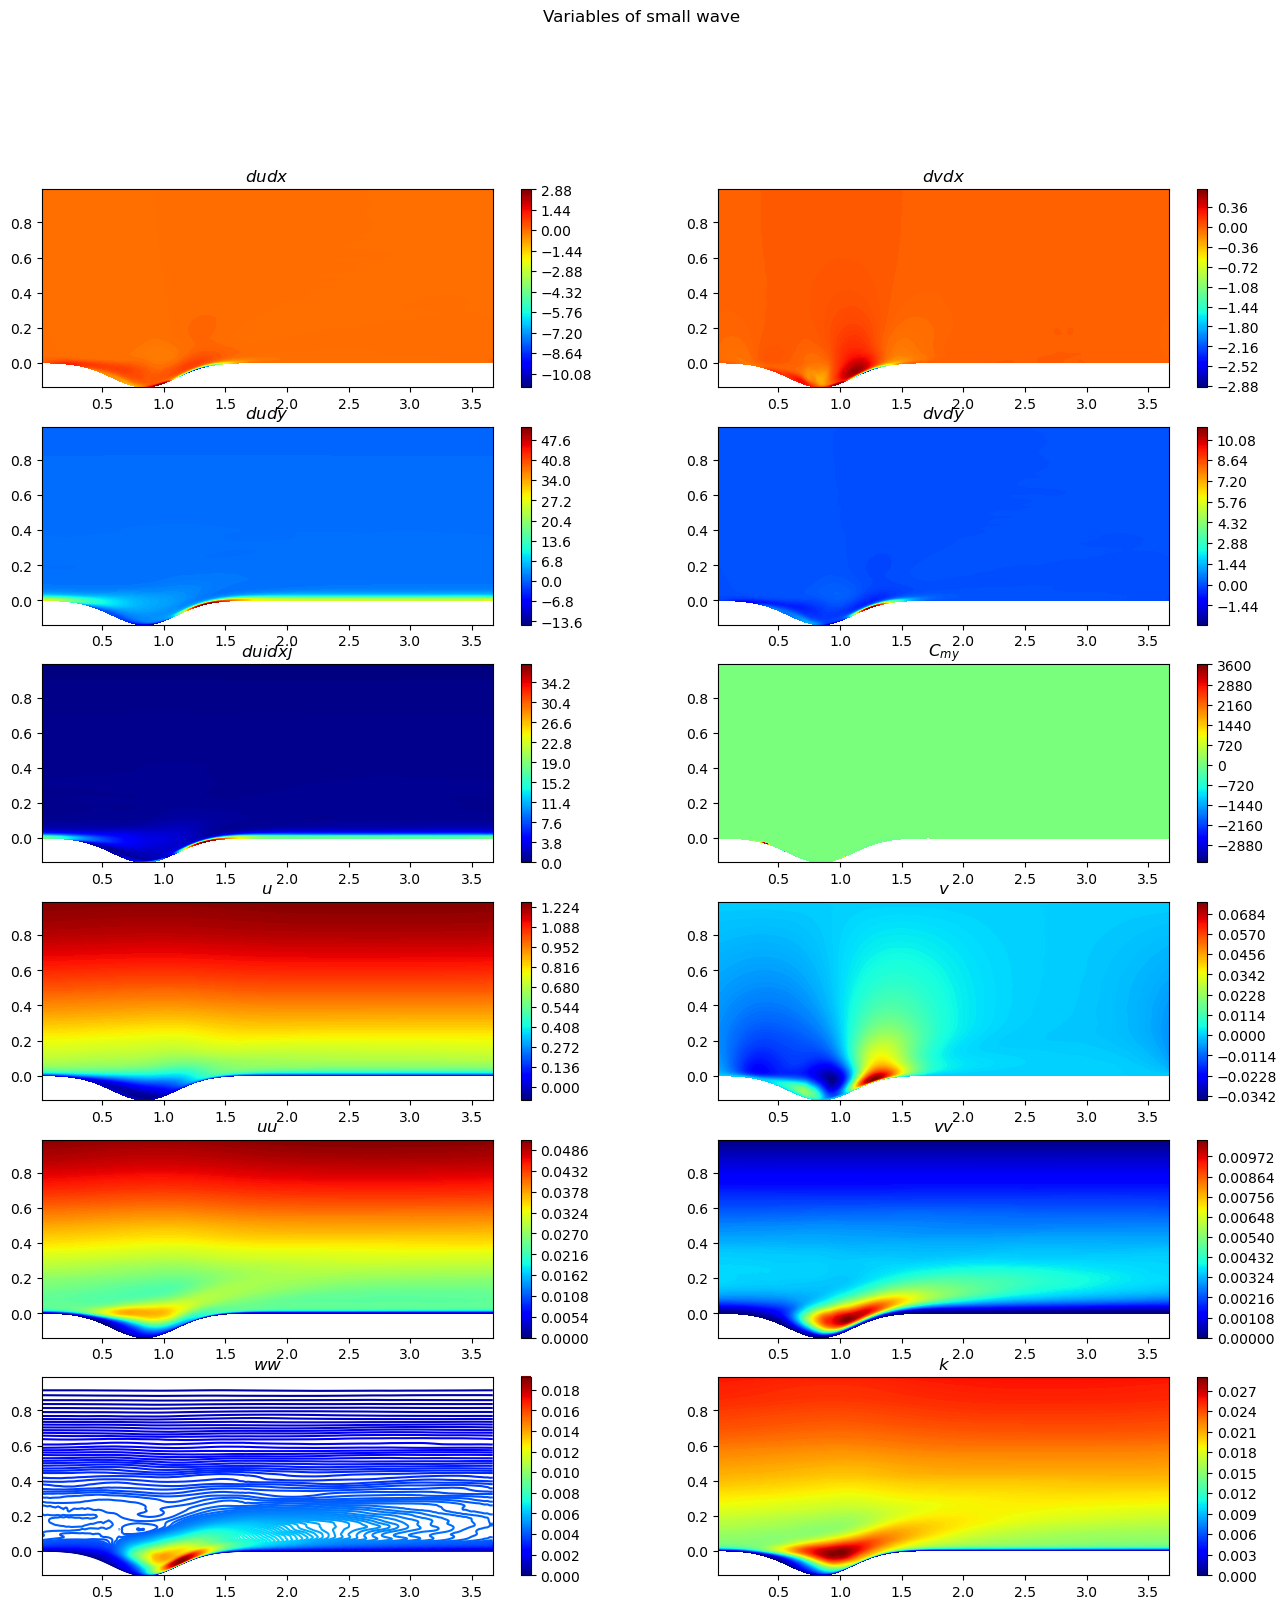

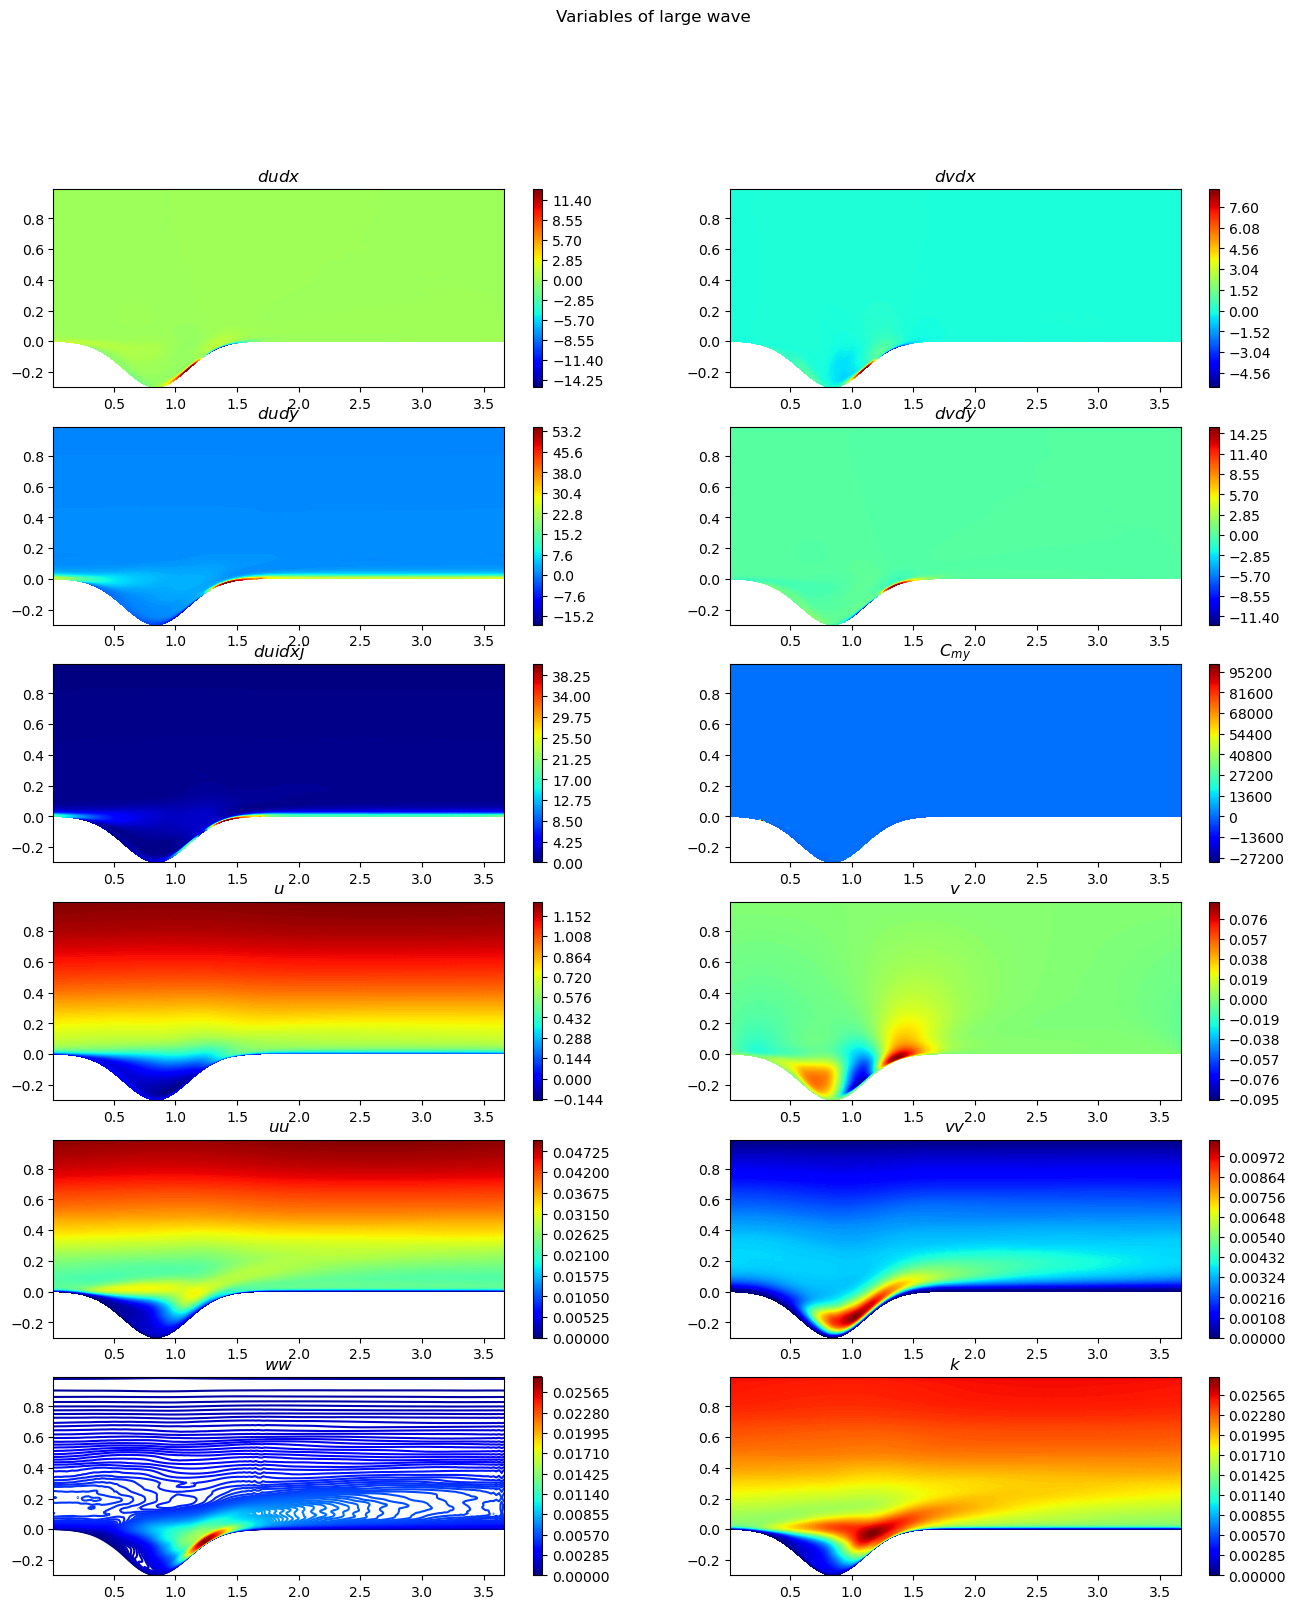

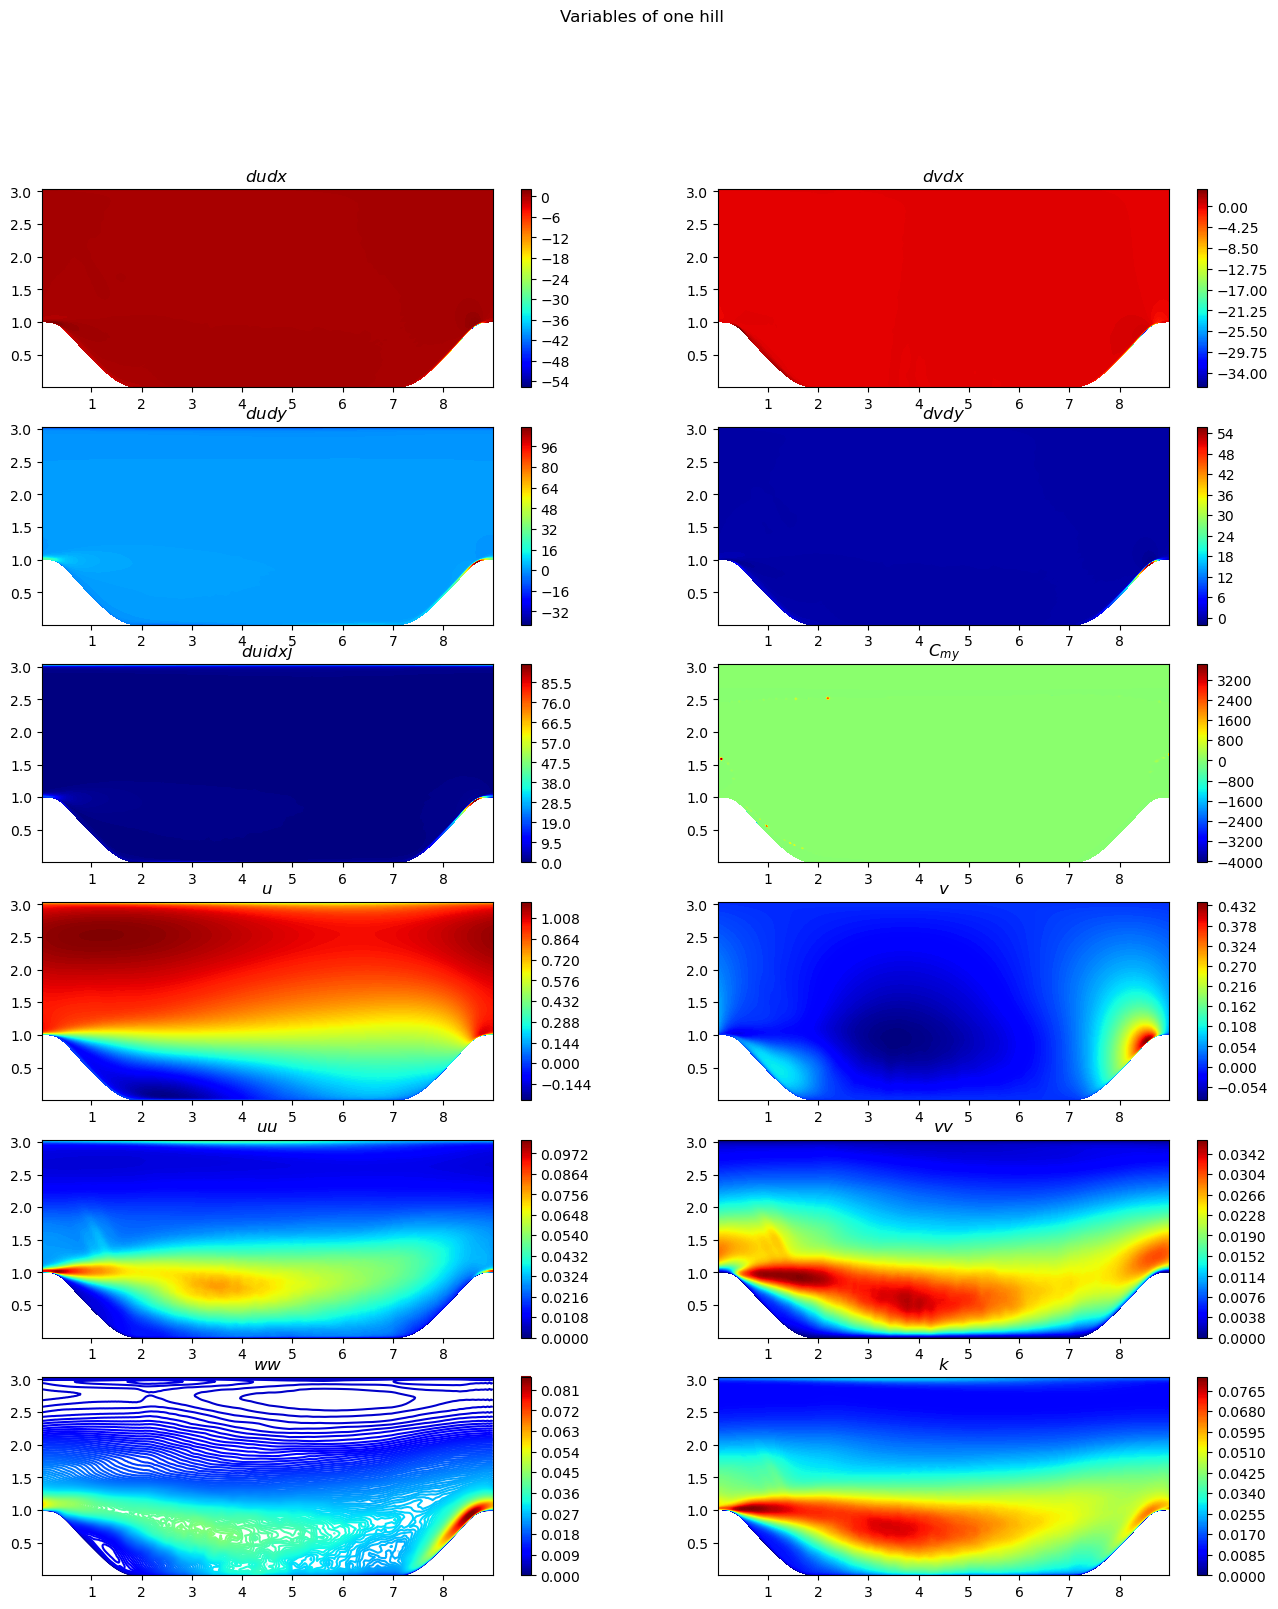

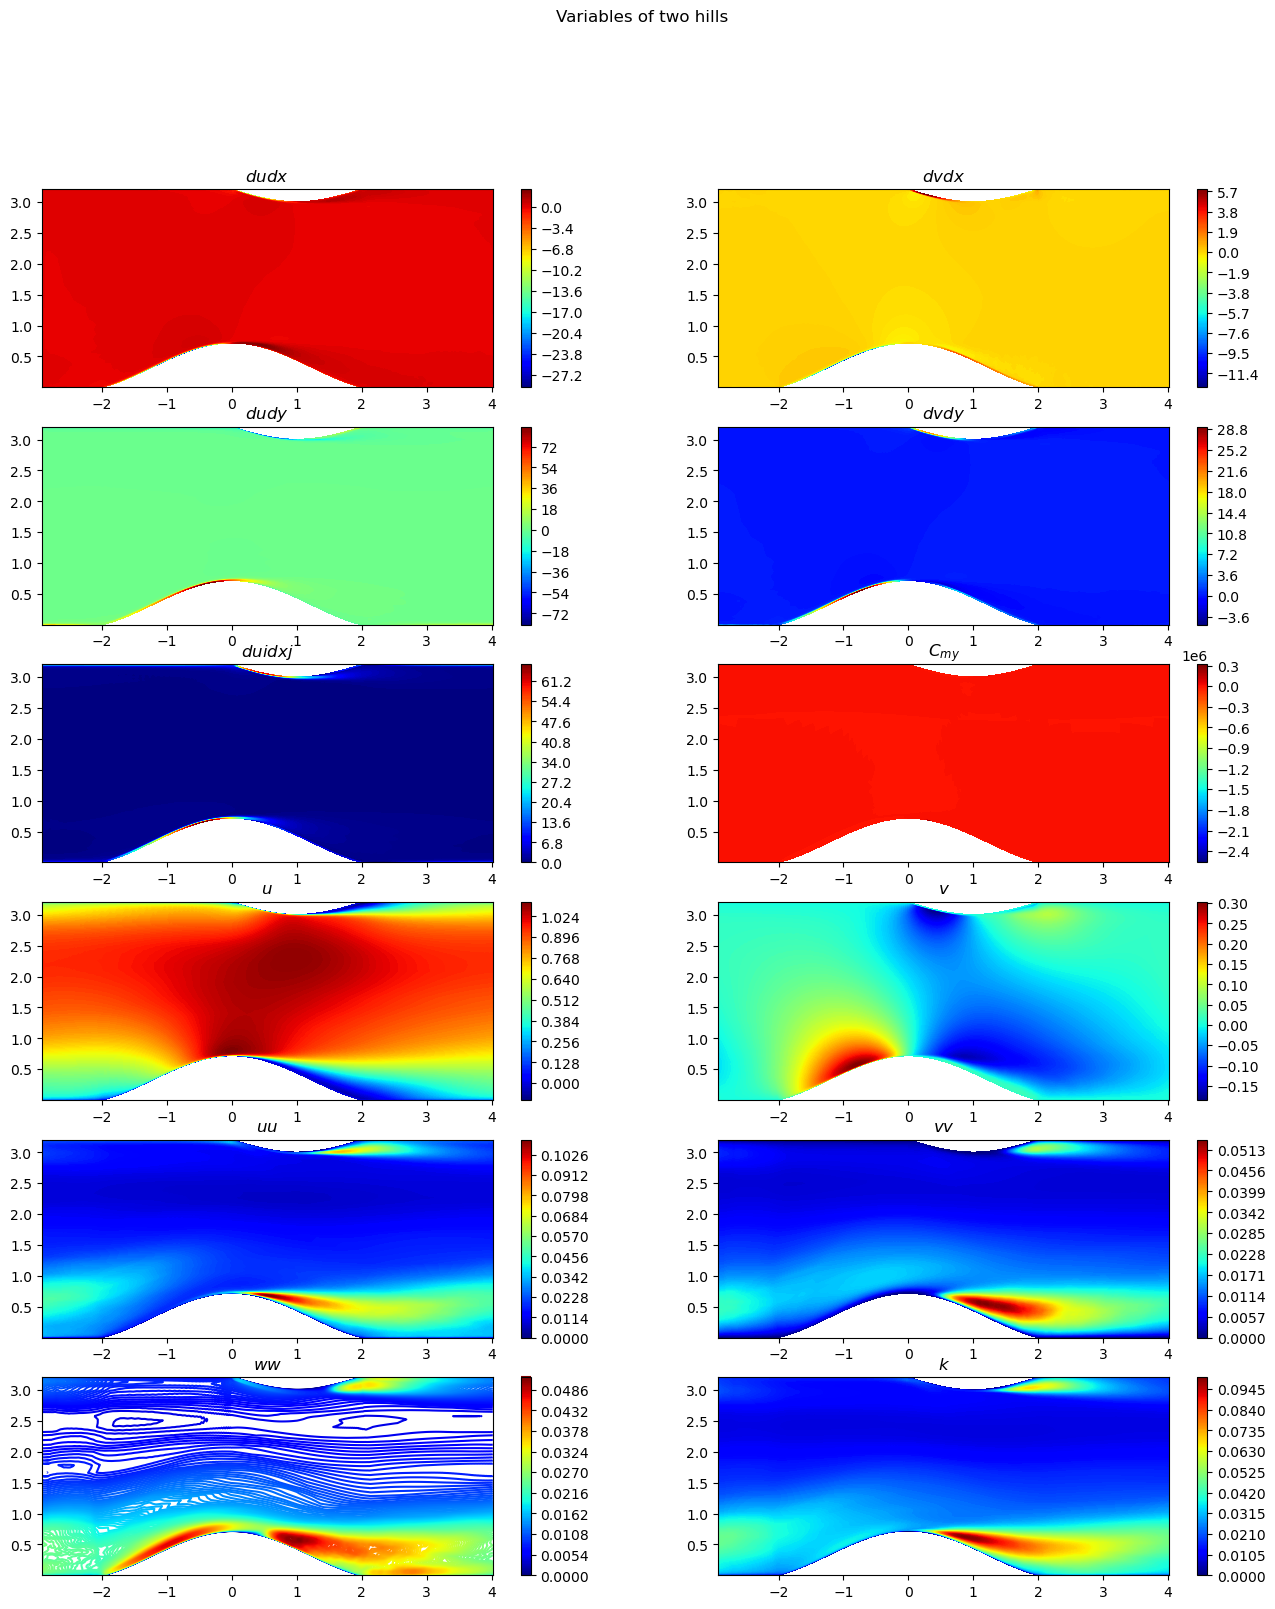

In [28]:
var_in_domain(x_SW, y_SW, dudx_SW, dvdx_SW, dudy_SW, dvdy_SW, duidxj_SW, cmy_SW, u_SW, v_SW, uu_SW, vv_SW, ww_SW, k_SW,'Variables of small wave')
var_in_domain(x_LW, y_LW, dudx_LW, dvdx_LW, dudy_LW, dvdy_LW, duidxj_LW, cmy_LW, u_LW, v_LW, uu_LW, vv_SW, ww_LW, k_LW,'Variables of large wave')
var_in_domain(x_OH, y_OH, dudx_OH, dvdx_OH, dudy_OH, dvdy_OH, duidxj_OH, cmy_OH, u_OH, v_OH, uu_OH, vv_OH, ww_OH, k_OH,'Variables of one hill')
var_in_domain(x_TH, y_TH, dudx_TH, dvdx_TH, dudy_TH, dvdy_TH, duidxj_TH, cmy_TH, u_TH, v_TH, uu_TH, vv_TH, ww_TH, k_TH,'Variables of two hills')


# Machine Learning 🤖

Since all machine learning models below are stored in "trained models" it is always faster to load them than running the code again. 😉

Set up the machine learning model, in this case we start by testing it on Small Wave(df_SW):

Plotting our results we see that this model performs okay on SW, and LW but does not work perticularily well on OH, and TH.

In [ ]:
# Choose in/out variable(s)
X=df_SW_scaled[['vv','uu','uv','dudx','dvdx','dudy','dvdy', 'duidxj']]
Y=df_SW['cmy']

# Split into trainig set and test set:
X_train_SW, X_test_SW, Y_train_SW, Y_test_SW = train_test_split(X, Y, test_size=0.2, random_state=42)
# when we split in training and test sets, we randomize the rows. 
# sklearn however, do not enjoy starting on some random row number, thus we create new row numbers starting at 1 again.
X_test_SW = X_test_SW.reset_index() 
Y_test_SW = Y_test_SW.reset_index()

The below model is already stored, run the cell after it to load it.

In [ ]:
# Choose model and fit it:
model = SVR(kernel='rbf', C=1, epsilon=0.01)
svr_SW = model.fit(X_train_SW, Y_train_SW)

# Save the model, now it can be opened again with:
#pickled_model = pickle.load(open('trained_models/svr_SW.pkl', 'rb'))
pickle.dump(svr_SW, open('trained_models/svr_SW.pkl','wb'))

In [ ]:
svr_SW = pickle.load(open('trained_models/svr_SW.pkl', 'rb'))

Trained on Large Wave, and Two Hills:

In [ ]:
# Load, and scale dataframe
df_LW_TH = pd.concat([df_LW,df_TH])
df_LW_TH_scaled = pd.concat([df_LW_scaled,df_TH_scaled])

# Choose in/out variable(s)
X=df_LW_TH_scaled[['vv','uu','uv','dudx','dvdx','dudy','dvdy', 'duidxj']]
Y=df_LW_TH['cmy']

# Split into trainig set and test set:
X_train_LW_TH, X_test_LW_TH, Y_train_LW_TH, Y_test_LW_TH = train_test_split(X, Y, test_size=0.2, random_state=42)
X_test_LW_TH = X_test_LW_TH.reset_index()
Y_test_LW_TH = Y_test_LW_TH.reset_index()

In [ ]:
# Choose model and fit it:
model = SVR(kernel='rbf', C=1, epsilon=0.01)
svr_LW_TH = model.fit(X_train_LW_TH, Y_train_LW_TH)

# Save the model, now it can be opened again with:
#pickled_model = pickle.load(open('trained_models/svr_LW_TH.pkl', 'rb'))
pickle.dump(svr_LW_TH, open('trained_models/svr_LW_TH.pkl','wb'))

In [ ]:
svr_LW_TH = pickle.load(open('trained_models/svr_LW_TH.pkl', 'rb'))

Let's test training on all available cases:

In [ ]:
# Load, and scale dataframe
df_all = pd.concat([df_SW,df_OH,df_LW,df_TH])
df_all_scaled = pd.concat([df_SW_scaled,df_OH_scaled,df_LW_scaled,df_TH_scaled])

# Choose in/out variable(s)
X=df_all_scaled[['vv','uu']]
Y=df_all['cmy']

# Split into trainig set and test set:
X_train_all, X_test_all, Y_train_all, Y_test_all = train_test_split(X, Y, test_size=0.2, random_state=42)
X_test_all = X_test_all.reset_index()
Y_test_all = Y_test_all.reset_index()

In [ ]:
# Choose model and fit it:
model = SVR(kernel='rbf', C=1, epsilon=0.01)
svr_all = model.fit(X_train_all, Y_train_all)

pickle.dump(svr_all, open('trained_models/svr_all.pkl','wb'))

In [ ]:
svr_all = pickle.load(open('trained_models/svr_all.pkl', 'rb'))

# Some more plotting 💹😎

Finally, lets plot some predictions from our ML models:

In [ ]:
#Adds a collumn to all unscaled dataframes, it takes three variables:
# col_name: the name of the new column, should be something like "pred cmu, training set".
# model: the pretrained model.
# input_var: an array of input variables, these should be the same variables as what the model was trained on.
# For example; on svr_SW the input_var should be: ['vv','uu','uv','dudx','dvdx','dudy','dvdy']
def df_with_pred(model, intput_var, col_name):
    df_LW[col_name] = model.predict(df_LW_scaled[intput_var])
    df_SW[col_name] = model.predict(df_SW_scaled[intput_var])
    df_OH[col_name] = model.predict(df_OH_scaled[intput_var])
    df_TH[col_name] = model.predict(df_TH_scaled[intput_var])

# Takes a column name from the dataframes and reshapes it to the domain dimentions. 
# Returns it for the specific dimentions of each domain. 
# col name: the name of the column that should be reshaped
def reshape_to_domain(col_name):
    pred_cmy_SW = df_SW[col_name].values.reshape(192,168).transpose()
    pred_cmy_LW = df_LW[col_name].values.reshape(192,168).transpose()
    pred_cmy_OH = df_OH[col_name].values.reshape(160,160).transpose()
    pred_cmy_TH = df_TH[col_name].values.reshape(160,400).transpose()

    return pred_cmy_SW, pred_cmy_LW, pred_cmy_OH, pred_cmy_TH    


First, our model trained only on Small Wave:

In [ ]:
df_with_pred(svr_SW, ['vv','uu','uv','dudx','dvdx','dudy','dvdy', 'duidxj'], 'pred cmu SW')
pred_cmy_SW_SW, pred_cmy_LW_SW, pred_cmy_OH_SW, pred_cmy_TH_SW = reshape_to_domain('pred cmu SW')

print('Predicted v actual cmu in domain, trained only on Small Wave')
cmu_v_pred_in_domain(x_SW, y_SW, pred_cmy_SW_SW, cmy_SW, 'Small Wave')
cmu_v_pred_in_domain(x_LW, y_LW, pred_cmy_LW_SW, cmy_LW, 'Large Wave')
cmu_v_pred_in_domain(x_OH, y_OH, pred_cmy_OH_SW, cmy_OH, 'One Hill')
cmu_v_pred_in_domain(x_TH, y_TH, pred_cmy_TH_SW, cmy_TH, 'Two Hills')

The model trained on is Large Wave, and Two Hills:

In [ ]:
df_with_pred(svr_LW_TH, ['vv','uu','uv','dudx','dvdx','dudy','dvdy'], 'pred cmu LW-TH')
pred_cmy_SW_LW_TH, pred_cmy_LW_LW_TH, pred_cmy_OH_LW_TH, pred_cmy_TH_LW_TH = reshape_to_domain('pred cmu LW-TH')

print('Predicted v actual cmu in domain, trained on Large Wave, and Two Hills')
cmu_v_pred_in_domain(x_SW ,y_SW, pred_cmy_SW_LW_TH, cmy_SW, 'Small Wave')
cmu_v_pred_in_domain(x_LW ,y_LW, pred_cmy_LW_LW_TH, cmy_LW, 'Large Wave')
cmu_v_pred_in_domain(x_OH ,y_OH, pred_cmy_OH_LW_TH, cmy_OH, 'One Hill')
cmu_v_pred_in_domain(x_TH ,y_TH, pred_cmy_TH_LW_TH, cmy_TH, 'Two Hills')

In [ ]:
df_with_pred(svr_all, ['vv','uu'], 'pred cmu all')
pred_cmy_SW_all, pred_cmy_LW_all, pred_cmy_OH_all, pred_cmy_TH_all = reshape_to_domain('pred cmu all')

print('Predicted v actual cmu in domain, trained 80 percent of all datasets')
cmu_v_pred_in_domain(x_SW, y_SW, pred_cmy_SW_all, cmy_SW, 'Small Wave')
cmu_v_pred_in_domain(x_LW, y_LW, pred_cmy_LW_all, cmy_LW, 'Large Wave')
cmu_v_pred_in_domain(x_OH, y_OH, pred_cmy_OH_all, cmy_OH, 'One Hill')
cmu_v_pred_in_domain(x_TH, y_TH, pred_cmy_TH_all, cmy_TH, 'Two Hills')

# Calculating error ❌

-------------------------------------Calculate Error with Sklearn metrics-------------------------------- 

### But WTF is RMS exactly? why are we interested in it?

Mean absolute error: This is the average of absolute errors of all the data points in the given dataset.  

Mean squared error: This is the average of the squares of the errors of all the data points in the given dataset.  
It is one of the most popular metrics out there!  

Median absolute error: This is the median of all the errors in the given dataset.  
The main advantage of this metric is that it's robust to outliers.  
A single bad point in the test dataset wouldn't skew the entire error metric, as opposed to a mean error metric.  

Explained variance score: This score measures how well our model can account for the variation in our dataset.  
A score of 1.0 indicates that our model is perfect.  

R2 score: This is pronounced as R-squared, and this score refers to the coefficient of determination.  
This tells us how well the unknown samples will be predicted by our model.  
The best possible score is 1.0, but the score can be negative as well.  

In [ ]:

def error_cal(real, pred, title): 
    df_ones = pd.DataFrame({
        'ones':(real/real)
        }) 
    
    ones = df_ones['ones']
    
    rms     = (np.std(pred - real)) / (np.mean(pred ** 2)) ** 0.5
    rms_1   = (np.std(ones - real)) / (np.mean(ones ** 2)) ** 0.5
    
    mae     = sm.mean_absolute_error(real, pred)
    mae_1   = sm.mean_absolute_error(real, ones)

    mse     = sm.mean_squared_error(real, pred)
    mse_1   = sm.mean_squared_error(real, ones)

    medae   = sm.median_absolute_error(real, pred)
    medae_1 = sm.median_absolute_error(real, ones)

    evs     = sm.explained_variance_score(real, pred)
    evs_1   = sm.explained_variance_score(real, ones)
    
    r2      = sm.r2_score(real, pred)
    r2_1    = sm.r2_score(real, ones)

    # print(title)
    # print('RMS error for ml:                      ', rms )
    # print('RMS error for C_my = 1:                ', rms_1, '\n' )
    # print('Mean absolute error for ml:            ', mae)
    # print('Mean absolute error for C_my = 1:      ', mae_1, '\n')
    # print('Mean squared error for ml:             ', mse)
    # print('Mean squared error for C_my = 1:       ', mse_1, '\n')
    # print('Median absolute error for ml:          ', medae)
    # print('Median absolute error for C_my = 1:    ', medae_1, '\n')
    # print('Explained variance score for ml:       ', evs)
    # print('Explained variance score for C_my = 1: ', evs_1, '\n')
    # print('R^2 score for ml:                      ', r2)
    # print('R^2 score for C_my = 1:                ', r2_1, '\n')

    table = PrettyTable()
    table.header = False
    table.title = title
    table.align = 'l'
    table.hrules=ALL
    table.add_rows([
        ['RMS error for ml', rms],
        ['RMS error for C_my = 1',rms_1],
        ['Mean absolute error for ml', mae],
        ['Mean absolute error for C_my = 1', mae_1],
        ['Mean squared error for ml', mse],
        ['Mean squared error for C_my = 1', mse_1],
        ['Median absolute error for ml', medae],
        ['Median absolute error for C_my = 1', medae_1],
        ['Explained variance score for ml', evs],
        ['Explained variance score for C_my = 1', evs_1],
        ['R^2 score for ml', r2],
        ['R^2 score for C_my = 1', r2_1],
    ])
    print(table)

In [ ]:
error_cal(df_LW['cmy'], df_LW['pred cmu SW'],'Checking error on Large Wave with the model trained only on Small Wave')

In [ ]:
error_cal(df_OH['cmy'], df_OH['pred cmu SW'],'Checking error on One Hill with the model trained only on Small Wave')

In [ ]:
error_cal(df_OH['cmy'], df_OH['pred cmu SW'],'Checking error on Two Hills with the model trained only on Small Wave')

# More plotting methods below:

They work, but interactive 3D plots takes up a wild amount of memory 🥲

scatter_3d(df_LW,df_LW['x'],df_LW['y'],df_LW['predicted cmy'], 'LW predicted cmy in domain')
scatter_3d(df_LW,df_LW['x'],df_LW['y'],df_LW['cmy'], 'cmy in domain')

scatter_w_pred(X_test_test_2, X_test_test_2['vv'], X_test_test_2['uu'], Y_test_test_2['cmy'], svr_test_2, "Scatter Plot with Prediction Surface")
scatter_w_pred(df_OH_scaled, df_OH_scaled['vv'], df_OH_scaled['uu'], df_OH['cmy'], svr_test_2, "Scatter Plot with Prediction Surface, One Hill")
scatter_w_pred(df_SW_scaled, df_SW_scaled['vv'], df_SW_scaled['uu'], df_SW['cmy'], svr_test_2, "Scatter Plot with Prediction Surface, Small Wave")


scatter_w_pred(X_test_test, X_test_test['vv'], X_test_test['uu'], Y_test_test['cmy'], svr_test, "Scatter Plot with Prediction Surface")

scatter_w_pred(df_TH_scaled, df_TH_scaled['vv'], df_TH_scaled['uu'], df_TH['cmy'], svr_test, "Scatter Plot with Prediction Surface, Two Hills")
scatter_w_pred(df_OH_scaled, df_OH_scaled['vv'], df_OH_scaled['uu'], df_OH['cmy'], svr_test, "Scatter Plot with Prediction Surface, One Hill")
scatter_w_pred(df_SW_scaled, df_SW_scaled['vv'], df_SW_scaled['uu'], df_SW['cmy'], svr_test, "Scatter Plot with Prediction Surface, Small Wave")
scatter_w_pred(df_LW_scaled, df_LW_scaled['vv'], df_LW_scaled['uu'], df_LW['cmy'], svr_test, "Scatter Plot with Prediction Surface, Large Wave")